In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 1.0.0
torchvision verseion: 0.2.1
Is GPU avaibale: True


In [2]:
# general settings (バッチサイズとデバイス)
batchsize = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード(今回はMNIST)
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../../data/MNIST',
                                 train = True,
                                 transform = tf,
                                 download = False)
mnist_validation = datasets.MNIST(root = '../../data/MNIST',
                                      train = False,
                                      transform = tf)

# データローダーを作成
mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = False)

print('the number of training data:', len(mnist_train))
print('the number of validation data:', len(mnist_validation))

the number of training data: 60000
the number of validation data: 10000


torch.Size([1, 28, 28])


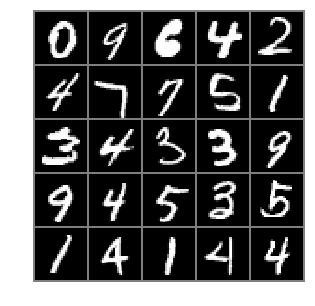

In [4]:
# 可視化のための関数
def show_image(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = iter(mnist_train_loader).next()
# 25画像をまとめて表示
show_image(make_grid(images[:25], nrow=5, padding=1))
# 画像の形状（channel, height, width）
print(images[0].size())

In [6]:
# Actnormの実装
class ActNorm2d(nn.Module):
    def __init__(self, num_features):
        super(ActNorm2d, self).__init__()
        size = [1, num_features, 1, 1]
        self.register_parameter('bias', nn.Parameter(torch.zeros(*size)))
        self.register_parameter('log_s', nn.Parameter(torch.zeros(*size)))
        self.inited = False
        
    def forward(self, x):
        if not self.inited:
            self.initialize_parameters(x)
        
        z = (x + self.bias) * torch.exp(self.log_s)
        log_det_jacobian = self.calculate_log_det_jacobian(x)
        return z, log_det_jacobian
    
    def inverse(self, z):
        x = z / torch.exp(self.log_s) - self.bias
        return x

    def calculate_log_det_jacobian(self, x):
        h, w = x.size(2), x.size(3)
        return h * w * torch.sum(self.log_s)
    
    def initialize_parameters(self, first_minibatch_x):
        # cloneいるか？ .detachこれでいい？
        bias = -1.0 * self.multidim_mean(first_minibatch_x.clone().detach(), dims=[0, 2, 3])
        var_s = self.multidim_mean((first_minibatch_x.clone().detach() + bias) ** 2, dims=[0, 2, 3])
        log_s = torch.log(1 / (torch.sqrt(var_s) + 1e-6))
        
        self.bias.data.copy_(bias.data)
        self.log_s.data.copy_(log_s.data)
        
        self.inited = True
            
    def multidim_mean(self, tensor, dims):
        dims = sorted(dims)
        for d in dims:
            tensor = tensor.mean(dim=d, keepdim=True)
        return tensor

In [7]:
# invertible 1x1 convolutionの実装
class Invertible1x1Conv2d(nn.Module):
    def __init__(self, num_features):
        super(Invertible1x1Conv2d, self).__init__()
        self.conv = nn.Conv2d(num_features, num_features, kernel_size=1, stride=1, padding=0, bias=False)
        
        W = torch.qr(torch.FloatTensor(num_features, num_features).normal_())[0]
        
        if torch.det(W) < 0:
            W[:,0] = -W[:,0]
        
        self.conv.weight.data = W.unsqueeze(2)
        
    def forward(self, x):
        z = self.conv(x)
        log_det_jacobian = self.calculate_log_det_jacobian(x)
        return z, log_det_jacobian
        
    def inverse(self, z):
        W = self.conv.weight.squeeze()
        if not hasattr(self, 'W_inverse'):
            W_inverse = W.inverse()
            W_inverse = torch.autograd.Variable(W_inverse.unsqueeze(2)) # Variableいるか？
            self.W_inverse = W_inverse
        x = F.conv2d(z, self.W_inverse, bias=None, stride=1, padding=0)
        return x
        
    def calculate_log_det_jacobian(self, x):
        W = self.conv.weight.squeeze()
        h, w = x.size(2), x.size(3)
        return h * w * torch.logdet(W)

In [8]:
# coupling layerで使われるCNN
class CNN(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(CNN, self).__init__()
        self.cv1 = nn.Conv2d(n_in, n_hidden, kernel_size=3, stride=1, padding=1)
        self.cv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, stride=1, padding=1)
        self.cv3 = nn.Conv2d(n_hidden, n_out, kernel_size=3, stride=1, padding=1)
        self.cv3.weight.data.zero_()
        self.cv3.bias.data.zero_()
        
    def forward(self, CNN_input):
        out = F.relu(self.cv1(CNN_input))
        out = F.relu(self.cv2(out))
        out = self.cv3(out)
        return out

In [10]:
# coupling layerの実装
class CouplingLayer(nn.Module):
    def __init__(self, num_features, affine=True):
        super(CouplingLayer, self).__init__()
        
        assert(num_features % 2 == 0)
        self.n_half = int(num_features / 2)
        self.affine = affine
        
        if self.affine:
            self.CNN = CNN(self.n_half, self.n_hideen, self.n_half*2)
        else:
            self.CNN = CNN(self.n_half, self.n_hidden, self.n_half)
            
    def forward(self, x):
        x_a = x[:,:self.n_half,:,:]
        x_b = x[:,self.n_half:,:,:]
        
        CNN_output = self.CNN(x_a)
        
        if self.affine:
            log_s = CNN_output[:,:self.n_half,:,:]
            bias = CNN_output[:,self.n_half:,:,:]
            z_b = (x_b + bias) * torch.exp(log_s)
        else:
            log_s = None
            z_b = x_b + CNN_output
            
        z = torch.cat([x_a, z_b], dim=1)
        log_det_jacobian = self.calculate_log_det_jacobian(log_s)
        return z, log_det_jacobian
        
    def inverse(self, z):
        z_a = z[:,:self.n_half,:,:]
        z_b = z[:,self.n_half:,:,:]
        
        CNN_output = self.CNN(z_a)
        
        if self.affine:
            log_s = CNN_output[:,:self.n_half,:,:]
            bias = CNN_output[:,self.n_half:,:,:]
            x_b = z_b / torch.exp(log_s) - bias
        else:
            x_b = z_b - CNN_output
            
        x = torch.cat([z_a, x_b], dim=1)
        return x
        
    def calculate_log_det_jacobian(self, log_s):
        if self.affine:
            return torch.sum(log_s)
        else:
            return 0.0


In [24]:
# 上３つをまとめたFlow
class StepofFlow(nn.Module):
    def __init__(self, num_features, affine=True):
        super(StepofFlow, self).__init__()

    def forward(self, x):
        1+1
    def inverse(self, z):
        1+1

In [ ]:
# Glow本体
class Glow(nn.Module):
    def __init__(self):
        super(Glow, self).__init__()
        
    def forward(self, x):
        1+1
    
    def inverse(self, z):
        1+1
        
    def squeeze(self, x):
        1+1
    def unsqueeze(self, z):
        1+1